In [1]:
import pickle

In [3]:
with open("curves/anotation_new_label_140.curves.", 'rb') as pickle_file:
    curve_fragment = pickle.load(pickle_file)

In [4]:
cfs = [[] for i in range(46)]

for cols in curve_fragment:
    for i in range(len(cols)):
        cfs[i] += cols[i]

In [5]:
for i in range(len(cfs)):
    print(len(cfs[i]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3088
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
47444
0
22152
21482
33074
0
29500
14804
0
0
0
0
0
0
19414


<IPython.core.display.Javascript object>


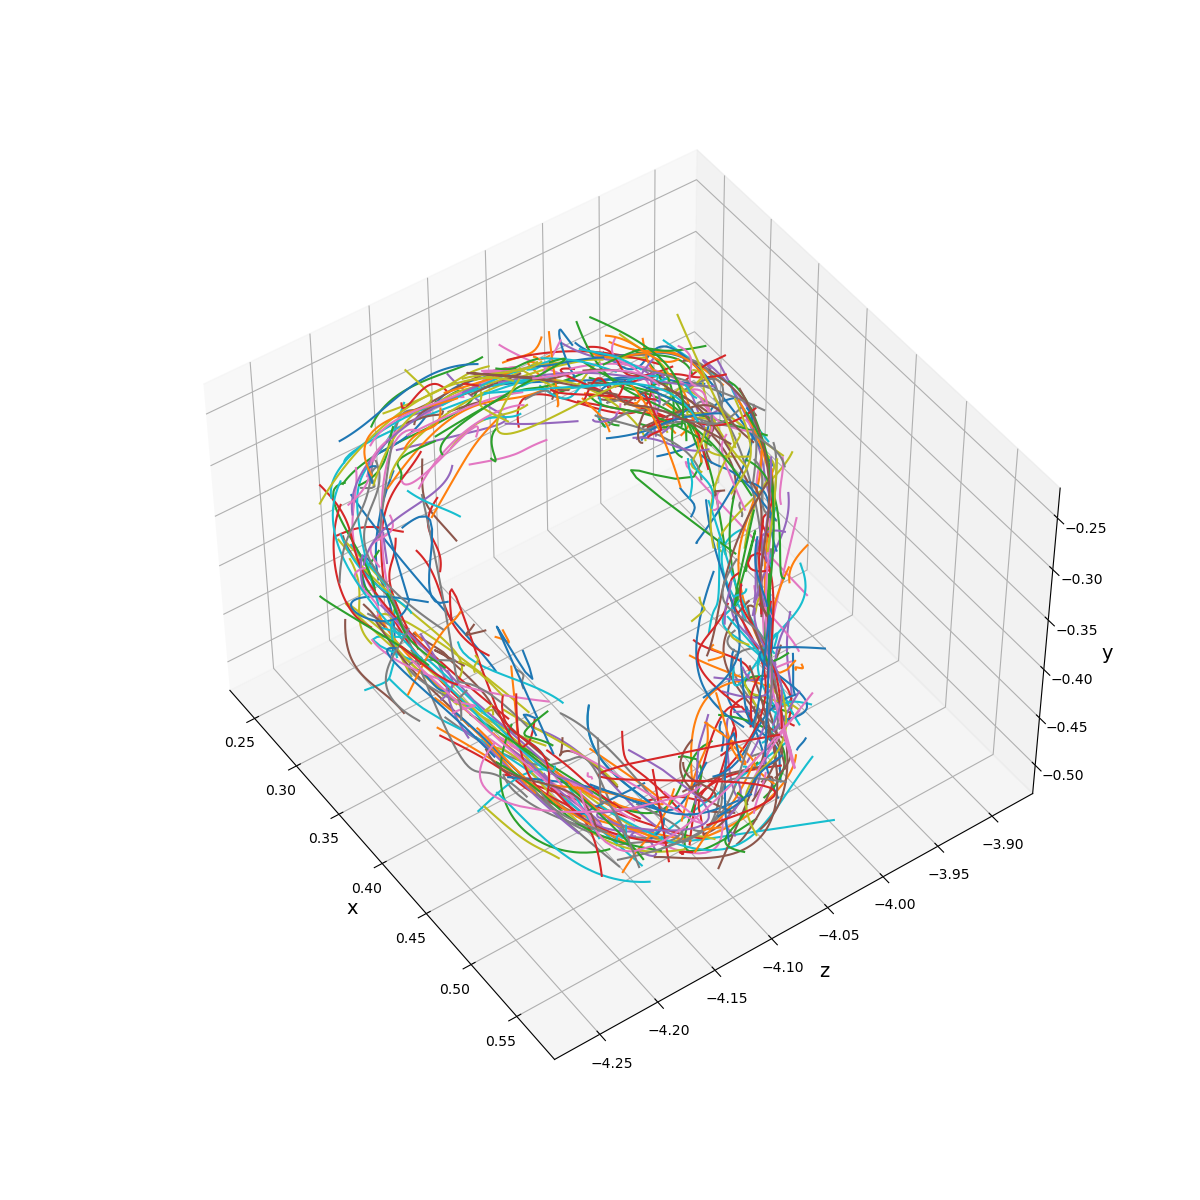

In [7]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%matplotlib notebook

def plot_graph():
    color_arr = np.array([[0,255,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    l = []
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if frag.size < 10:
                continue
            #print(frag)
            if i != 31:
                continue
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            new = interpolate.splev(u, tck, der=0)
            #c = color_arr[i]/255
            if j % 100 == 0:
                ax.plot(new[0], new[2], new[1],"-")
                l.append(frag)
            
            j+=1
    return l

        
        
        #ax.plot(x, z, y,"-")

fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
#ax.set_box_aspect((1,1,1))
#ax.set_xticks(np.arange(-4,4,1))
#ax.set_yticks(np.arange(-4,4,1))
#ax.set_zticks(np.arange(-2,9,1))

cluster = plot_graph()

In [140]:
import itertools
import open3d as o3d

In [141]:
flatten_curve_frag = np.array(list(itertools.chain.from_iterable(cluster)))
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(flatten_curve_frag)

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(
        pcd.cluster_dbscan(eps=0.01, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
i = 0
for x,y,z in flatten_curve_frag[np.where(labels == 0)]:
    if i%10==0:
        ax.plot(x, z, y,".",c="#9FC963")
    i+=1

In [142]:
cluster = flatten_curve_frag#[::10]


In [143]:
import sklearn
from sklearn.decomposition import PCA

In [144]:
pca = PCA()
pca.fit(cluster)
feature = pca.transform(cluster)

<IPython.core.display.Javascript object>


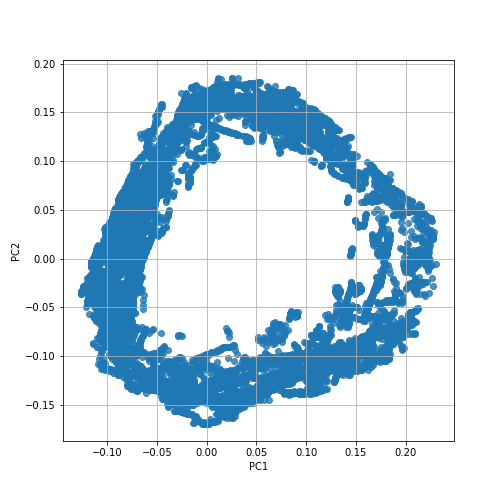

In [145]:
plt.figure(figsize=(7, 7))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [146]:
r = (feature[:, 0]**2 + feature[:, 1]**2)**(1/2)
cos = feature[:, 0]/r
sin = feature[:, 1]/r

arccos = np.arccos(cos)
arcsin = np.arcsin(sin)
arccos_m = -arccos
arcsin_m = -np.pi -arcsin
arcsin_p = np.pi - arcsin

In [147]:
def same_checker(ls):
    for i, num1 in enumerate(ls):
        for j, num2 in enumerate(ls):
            if i == j:
                continue
            if np.abs(num1 - num2) <0.0005:
                return num1

In [148]:
feature_theta = []
for temp_list in zip(arccos, arcsin, arccos_m, arcsin_m, arcsin_p):
    theta = same_checker(temp_list)
    feature_theta.append(theta)
feature_theta = np.array(feature_theta)

In [149]:
cluster_ex_nan = cluster[np.where(feature_theta != None)]
feature_theta_ex_nan = feature_theta[np.where(feature_theta != None)]
sorted_idx = np.argsort(feature_theta_ex_nan)
sorted_cluster = cluster_ex_nan[sorted_idx]

In [150]:
from scipy import interpolate
from scipy import ndimage

In [151]:
x = sorted_cluster[:,0]
y = sorted_cluster[:,2]
z = sorted_cluster[:,1]
data = [x,y,z]

jump = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2) 
smooth_jump = ndimage.gaussian_filter1d(jump, 5, mode='wrap')  # window of size 5 is arbitrary
limit = 2*np.median(smooth_jump)    # factor 2 is arbitrary
xn, yn, zn = x[:-1], y[:-1], z[:-1]
xn = xn[(jump > 0) & (smooth_jump < limit)]
yn = yn[(jump > 0) & (smooth_jump < limit)]
zn = zn[(jump > 0) & (smooth_jump < limit)]

data = [xn[::10],yn[::10],zn[::10]]

In [160]:
tck, u = interpolate.splprep(data, s=0.88, k=3, per=1)
new = interpolate.splev(u, tck, der=0)
prossed_data = np.array(new)

C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[0][1497]=x[0][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[1][1497]=x[1][0]
  (i, m, i)))
C:\Users\murata\anaconda3\envs\py37cv\lib\site-packages\scipy\interpolate\_fitpack_impl.py:227: RuntimeWarning: Setting x[2][1497]=x[2][0]
  (i, m, i)))


<IPython.core.display.Javascript object>


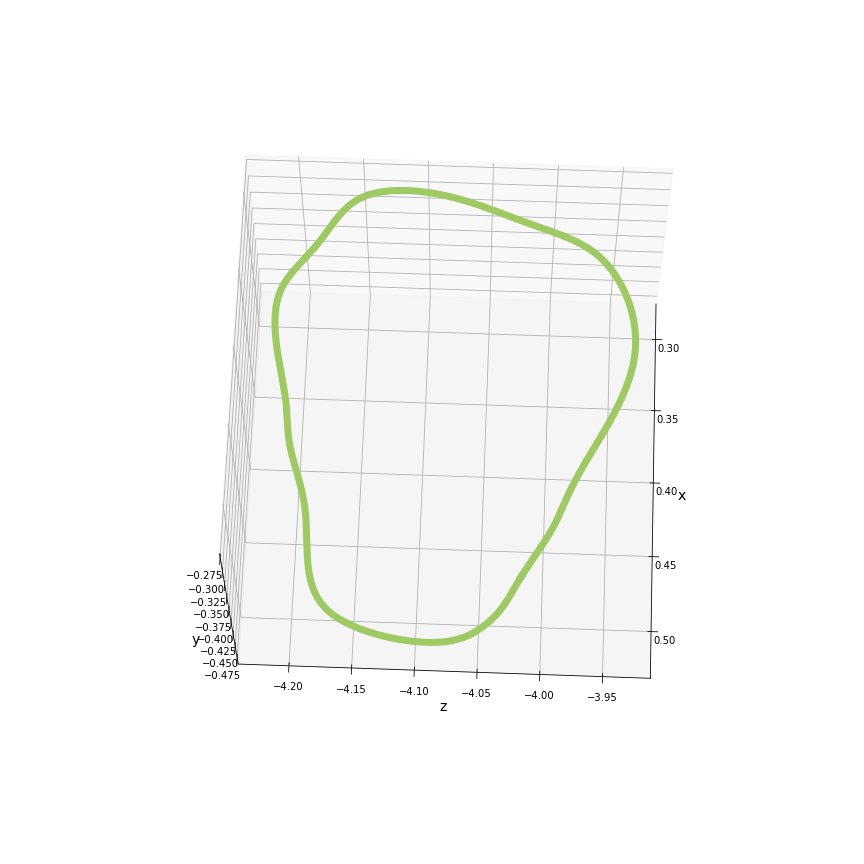

In [161]:
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
x, y, z = prossed_data[0],prossed_data[2],prossed_data[1]
ax.plot(x, z, y,"-",c="#9FC963",linewidth = 7.0)

In [162]:
prossed_data

array([[ 0.47028339,  0.47045734,  0.470635  , ...,  0.47000735,
         0.47022867,  0.47028339],
       [-4.01758862, -4.01771204, -4.01783763, ..., -4.01739185,
        -4.01754971, -4.01758862],
       [-0.47843815, -0.47845536, -0.47847258, ..., -0.47841011,
        -0.47843266, -0.47843815]])

In [163]:
import pickle
with open("annotation_one_2_2.curve","wb") as f:
    pickle.dump(prossed_data, f)